1) L-CORE (patient's internal temperature in C): high (> 37), mid (>= 36 and <= 37), low (< 36)
2) L-SURF (patient's surface temperature in C): high (> 36.5), mid (>= 36.5 and <= 35), low (< 35)
3) L-O2 (oxygen saturation in %): excellent (>= 98), good (>= 90 and < 98), fair (>= 80 and < 90), poor (< 80)
4) L-BP (last measurement of blood pressure): high (> 130/90), mid (<= 130/90 and >= 90/70), low (< 90/70)
5) SURF-STBL (stability of patient's surface temperature): stable, mod-stable, unstable
6) CORE-STBL (stability of patient's core temperature): stable, mod-stable, unstable
7) BP-STBL (stability of patient's blood pressure) stable, mod-stable, unstable
8) COMFORT (patient's perceived comfort at discharge, measured as an integer between 0 and 20)
The main objective is to build a predictive model, which could help them in predicting where patients in a postoperative recovery area should be sent to next. Because hypothermia is a significant concern after surgery.
9) decision ADM-DECS (discharge decision): I (patient sent to Intensive Care Unit),S (patient prepared to go home),
A (patient sent to general hospital floor)

In [ ]:
import numpy as np
import pandas as pd
from numpy import math

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt
import seaborn as sns

Importing file 

In [ ]:
df=pd.read_csv('/post-operative (1).data',heder= None)

In [ ]:
df.head()

,0,1,2,3,4,5,6,7,8
0,mid,low,excellent,mid,stable,stable,stable,15,A
1,mid,high,excellent,high,stable,stable,stable,10,S
2,high,low,excellent,high,stable,stable,mod-stable,10,A
3,mid,low,good,high,stable,unstable,mod-stable,15,A
4,mid,mid,excellent,high,stable,stable,stable,10,A


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90 entries, 0 to 89
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   0       90 non-null     object
 1   1       90 non-null     object
 2   2       90 non-null     object
 3   3       90 non-null     object
 4   4       90 non-null     object
 5   5       90 non-null     object
 6   6       90 non-null     object
 7   7       90 non-null     object
 8   8       90 non-null     object
dtypes: object(9)
memory usage: 6.5+ KB


Data preprocessing

In [ ]:
df.rename(columns=
               {0 : 'core_temp' ,
                1 : 'surf_temp' ,
                2 : 'o2_satur' ,
                3 : 'bp' ,
                4 : 'surf_temp_stbl' ,
                5 : 'core_temp_stbl' ,
                6 : 'bp_stbl' ,
                7 : 'comfort' ,
                8 : 'decision'},inplace=True)

In [ ]:
df['core_temp']= df['core_temp'].replace({'high' : 2 , 'mid' : 1 ,'low' : 0})
df['surf_temp'] = df['surf_temp'].replace({'high' : 2 , 'mid' : 1 ,'low' : 0})
df['bp'] = df['bp'].replace({'high' : 2 , 'mid' : 1 ,'low' : 0})
df['surf_temp_stbl'] = df['surf_temp_stbl'].replace({'stable' : 2 , 'mod_stable' : 1 ,'unstable' : 0})
df['core_temp_stbl'] = df['core_temp_stbl'].replace({'stable' : 2 , 'mod_stable' : 1 ,'mod-stable' : 1 ,'unstable' : 0})
df['bp_stbl'] = df['bp'].replace({'stable' : 2 , 'mod_stable' : 1 ,'unstable' : 0})
df['o2_satur'] = df['o2_satur'].replace({'poor' : 0 , 'fair' : 1 , 'good' : 2 , 'excellent' : 3})
df['decision'] = df['decision'].replace({'I' : 0 , 'A' : 1 ,'A ' : 1, 'S' : 2})

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90 entries, 0 to 89
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   core_temp       90 non-null     int64 
 1   surf_temp       90 non-null     int64 
 2   o2_satur        90 non-null     int64 
 3   bp              90 non-null     int64 
 4   surf_temp_stbl  90 non-null     int64 
 5   core_temp_stbl  90 non-null     int64 
 6   bp_stbl         90 non-null     int64 
 7   comfort         90 non-null     object
 8   decision        90 non-null     int64 
dtypes: int64(8), object(1)
memory usage: 6.5+ KB


In [ ]:
df['comfort'].value_counts()

10    65
15    19
?      3
05     2
07     1
Name: comfort, dtype: int64

In [ ]:
df['comfort'] = df['comfort'].str.replace('?' , '10').astype(int)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  """Entry point for launching an IPython kernel.


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90 entries, 0 to 89
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   core_temp       90 non-null     int64
 1   surf_temp       90 non-null     int64
 2   o2_satur        90 non-null     int64
 3   bp              90 non-null     int64
 4   surf_temp_stbl  90 non-null     int64
 5   core_temp_stbl  90 non-null     int64
 6   bp_stbl         90 non-null     int64
 7   comfort         90 non-null     int64
 8   decision        90 non-null     int64
dtypes: int64(9)
memory usage: 6.5 KB


In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(df.drop('decision', axis = 1))
scaled_features = scaler.transform(df.drop('decision', axis = 1))
 
df_feat = pd.DataFrame(scaled_features, columns = df.columns[:-1])
df_feat.head()

,core_temp,surf_temp,o2_satur,bp,surf_temp_stbl,core_temp_stbl,bp_stbl,comfort
0,0.112509,-1.345166,1.045478,-0.570352,1.0,0.284975,-0.570352,1.810021
1,0.112509,1.607638,1.045478,1.330821,1.0,0.284975,1.330821,-0.403320
2,1.800141,-1.345166,1.045478,1.330821,1.0,0.284975,1.330821,-0.403320
3,0.112509,-1.345166,-0.956501,1.330821,1.0,-3.660837,1.330821,1.810021
4,0.112509,0.131236,1.045478,1.330821,1.0,0.284975,1.330821,-0.403320


In [ ]:
independent_variables = list(set(df_feat.columns.to_list()))

In [ ]:
feature_train, feature_test, target_train, target_test = train_test_split(scaled_features, df['decision'], test_size = 0.21)

In [ ]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(multi_class='multinomial',fit_intercept=True, max_iter=10000)
model.fit(feature_train, target_train)

LogisticRegression(max_iter=10000, multi_class='multinomial')

In [ ]:
train_preds = model.predict_proba(feature_train)
test_preds = model.predict_proba(feature_test)

In [ ]:
train_class_preds = model.predict(feature_train)
test_class_preds = model.predict(feature_test)

In [ ]:
train_class_preds

array([1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 2, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1])

In [ ]:
test_class_preds

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

 confusion_matrix

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix

In [ ]:
train_accuracy = accuracy_score(train_class_preds,target_train)
test_accuracy = accuracy_score(test_class_preds,target_test)

print("The accuracy on train data = ", train_accuracy)
print("The accuracy on test data = ", test_accuracy)

The accuracy on train data =  0.676056338028169
The accuracy on test data =  0.7368421052631579


In [ ]:
cm = confusion_matrix(target_test, test_class_preds)
print(cm)

[[14  0]
 [ 5  0]]


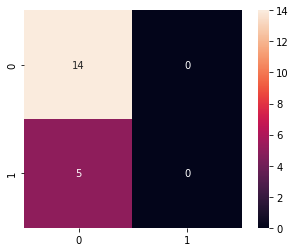

In [ ]:
sns.heatmap(cm,square = True,annot = True)

In [ ]:
from sklearn.tree import DecisionTreeClassifier,export_graphviz
from sklearn import tree
from IPython.display import SVG
from graphviz import Source
from IPython.display import display

In [ ]:
classf = DecisionTreeClassifier(criterion='entropy', max_leaf_nodes=8, max_depth=3 ,random_state=0)
classf.fit(feature_train,target_train)

DecisionTreeClassifier(criterion='entropy', max_depth=3, max_leaf_nodes=8,
                       random_state=0)

In [ ]:
y_predicted = classf.predict(feature_test)
y_predicted 

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [ ]:
accuracy_score(y_predicted , target_test)

0.7368421052631579

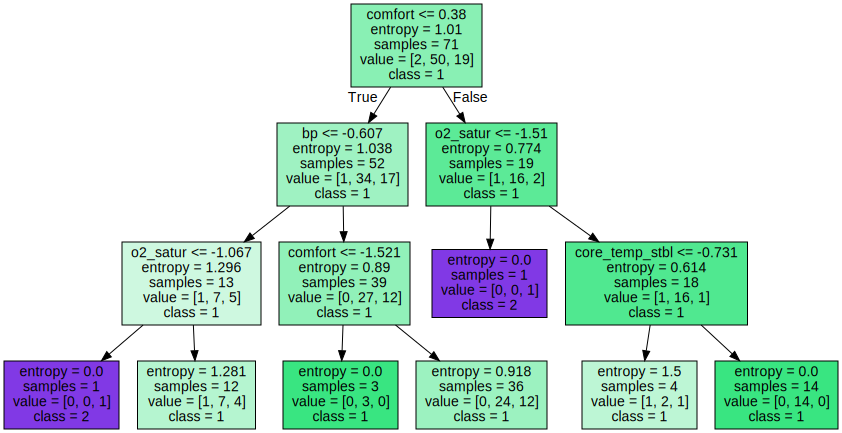

In [ ]:
graph = Source(tree.export_graphviz(classf, out_file=None
   , feature_names=independent_variables, class_names=['0', '1' , '2'] 
   , filled = True))
display(SVG(graph.pipe(format='svg')))

SVM

In [ ]:
from sklearn.svm import SVC
SVC_model = SVC().fit(feature_train , target_train)
test_svm = SVC_model.predict(feature_test)

In [ ]:
accuracy_score(test_svm, target_test)

0.7368421052631579

KNeighborsClassifier

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
 
knn = KNeighborsClassifier(n_neighbors = 11)
 
knn.fit(feature_train, target_train)
pred = knn.predict(feature_test)

In [ ]:
accuracy_score(pred , target_test)

0.7368421052631579

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
print(confusion_matrix(target_test, pred))
 
print(classification_report(target_test,pred))

[[14  0]
 [ 5  0]]
              precision    recall  f1-score   support

           1       0.74      1.00      0.85        14
           2       0.00      0.00      0.00         5

    accuracy                           0.74        19
   macro avg       0.37      0.50      0.42        19
weighted avg       0.54      0.74      0.63        19



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


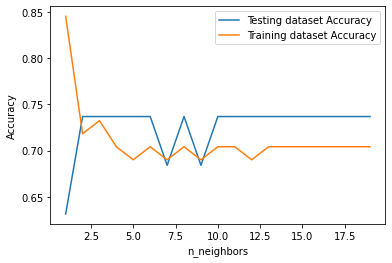

In [ ]:
neighbors = np.arange(1, 20)
train_accuracy = np.empty(len(neighbors))
test_accuracy = np.empty(len(neighbors))
  
for i, k in enumerate(neighbors):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(feature_train, target_train)
        
    train_accuracy[i] = knn.score(feature_train, target_train)
    test_accuracy[i] = knn.score(feature_test, target_test)
  
plt.plot(neighbors, test_accuracy, label = 'Testing dataset Accuracy')
plt.plot(neighbors, train_accuracy, label = 'Training dataset Accuracy')
  
plt.legend()
plt.xlabel('n_neighbors')
plt.ylabel('Accuracy')
plt.show()

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
knn_model = KNeighborsClassifier(n_neighbors=4).fit(feature_train, target_train)
tst_p = knn_model.predict(feature_test)
accuracy_score(target_test , tst_p)

0.7368421052631579